In [9]:
# Prepare data for 2D resnet for distances prediction
import numpy as np

In [1]:
def parse_lines(raw):
    return [[float(x) for x in line.split("\t") if x != ""] for line in raw]

def parse_line(line):
    return [float(x) for x in line.split("\t") if x != ""]

In [2]:
path = "../data/distanced/full_under_200.txt"
# Opn file and read text
with open(path, "r") as f:
    lines = f.read().split('\n')

In [3]:
# Scan first n proteins
names = []
seqs = []
dists = []

# Extract numeric data from text
for i,line in enumerate(lines):
    if len(names) == 403:
        break
    # Read each protein separately
    if line == "[ID]":
        names.append(lines[i+1])
    elif line == "[PRIMARY]":
        seqs.append(lines[i+1])
    elif line == "[DIST]":
        dists.append(parse_lines(lines[i+1:i+len(seqs[-1])+1]))
        # Progress control
        if len(names)%50 == 0:
            print("Currently @ ", len(names), " out of n (500)")

Currently @  50  out of n (500)
Currently @  100  out of n (500)
Currently @  150  out of n (500)
Currently @  200  out of n (500)
Currently @  250  out of n (500)
Currently @  300  out of n (500)
Currently @  350  out of n (500)
Currently @  400  out of n (500)


In [4]:
print("Names: ", len(names))
print("Seqs: ", len(seqs))
print("Dists: ", len(dists))

Names:  403
Seqs:  402
Dists:  402


In [5]:
def wider(seq, l=200, n=20):
    """ Converts a seq into a one-hot tensor. Not LxN but LxLxN"""
    key = "HRKDENQSYTCPAVLIGFWM"
    tensor = []
    for i in range(l):
        d2 = []
        for j in range(l):
            d1 = [1 if (j<len(seq) and i<len(seq) and key[x] == seq[i] and key[x] == seq[j]) else 0 for x in range(n)]
    
            d2.append(d1)
        tensor.append(d2)
    
    return np.array(tensor)

In [10]:
inputs = np.array([wider(seq) for seq in seqs])

In [11]:
inputs.shape

(402, 200, 200, 20)

In [12]:
# Embed number of rows
def embedding_matrix(matrix, l=200):
    # Embed with extra columns
    for i in range(len(matrix)):
        while len(matrix[i])<l:
            matrix[i].extend([0 for i in range(l-len(matrix[i]))])
    #Embed with extra rows
    while len(matrix)<l:
        matrix.append([0 for x in range(l)])
    return np.array(matrix)

In [13]:
dists = np.array([embedding_matrix(matrix) for matrix in dists])

In [14]:
def treshold(matrix, cuts=[1, 500, 1000, 1500, 2000], l=200):
    # Turns an L*L*1 tensor into an L*L*N 
    trash = (np.array(matrix)<cuts[0]).astype(np.int)
    first = (np.array(matrix)<cuts[1]).astype(np.int)-trash
    sec = (np.array(matrix)<cuts[2]).astype(np.int)-trash-first
    third = (np.array(matrix)<=cuts[3]).astype(np.int)-trash-first-sec
    fourth = np.array(matrix)>cuts[4]
    
    return np.concatenate((trash.reshape(l,l,1), first.reshape(l,l,1), sec.reshape(l,l,1), third.reshape(l,l,1), fourth.reshape(l,l,1)), axis=2)

In [15]:
outputs = np.array([treshold(d) for d in dists])

In [16]:
print(outputs.shape)

(402, 200, 200, 5)


In [17]:
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Embedding, Dropout, Flatten, UpSampling1D, UpSampling2D
from keras.layers.convolutional import Conv1D, Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling1D, AveragePooling1D, MaxPooling2D, AveragePooling2D
import keras.backend as K
import keras

from keras.layers import BatchNormalization, Activation
from keras.layers import Input
from keras.regularizers import l2
from keras.losses import mean_squared_error, mean_absolute_error

Using TensorFlow backend.


In [18]:
kernel_size, filters = 3, 16
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)

In [19]:
from keras.activations import softmax

def softMaxAxis1(x):
    return softmax(x,axis=2)

In [32]:
def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss

In [64]:
def resnet_block(inputs,
                 num_filters=64,
                 kernel_size=3,
                 strides=1,
                 activation='elu',
                 batch_normalization=True,
                 conv_first=False):
    """ # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)
    """
#    conv = Conv2D(num_filters,
#                  kernel_size=kernel_size,
#                  strides=strides,
#                  padding='same',
#                  kernel_initializer='he_normal',
#                  kernel_regularizer=l2(1e-4))

    x = inputs
    # down size
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = Conv2D(num_filters//2, kernel_size=1, strides=1, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(x)
    # Strided Calculations - cyclic strides - half filters
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = Conv2D(num_filters//2, kernel_size=3, strides=strides, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(x)
    # Up size
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = Conv2DTranspose(num_filters, kernel_size=1, strides=strides, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(x)
    return x

In [65]:
def resnet_layer(inputs,
                 num_filters=32,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=False):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [66]:
def resnet_v2(input_shape, depth, num_classes=4):
    """ResNet Version 2 Model builder [b] """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    # num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    striding = [1,2,4,8]
    for stage in range(8):
    # for res_block in range(num_res_blocks):
        activation = 'elu'
        batch_normalization = True


        # bottleneck residual unit
        y = resnet_block(inputs=x,
                         num_filters=16,
                         kernel_size=3,
                         strides=striding[stage%4])

        x = keras.layers.add([x, y])

    # Add a linear Conv classifier on top.
    # v2 has BN-ReLU before Pooling
    y = Conv2D(num_classes, kernel_size=1, strides=1, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(x)
    outputs = Activation(softMaxAxis1)(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [67]:
model = resnet_v2(input_shape=(200,200, 20), depth=20, num_classes=5)

In [68]:
model.compile(optimizer=adam, loss=weighted_categorical_crossentropy(np.array([0.01, 1.75, 1.25, 0.75, 0.35])), metrics=["accuracy"])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 200, 200, 20) 0                                            
__________________________________________________________________________________________________
conv2d_41 (Conv2D)              (None, 200, 200, 16) 2896        input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_53 (BatchNo (None, 200, 200, 16) 64          conv2d_41[0][0]                  
__________________________________________________________________________________________________
activation_57 (Activation)      (None, 200, 200, 16) 0           batch_normalization_53[0][0]     
__________________________________________________________________________________________________
batch_norm

In [60]:
his = model.fit(inputs, outputs, epochs=5, batch_size=4, verbose=1, shuffle=True, validation_split=0.1)

Train on 361 samples, validate on 41 samples
Epoch 1/10
361/361 [==============================] - 10s 27ms/step - loss: 0.2385 - acc: 0.4019 - val_loss: 0.1838 - val_acc: 0.4837
Epoch 2/10
361/361 [==============================] - 6s 18ms/step - loss: 0.2008 - acc: 0.4841 - val_loss: 0.1751 - val_acc: 0.5447
Epoch 3/10
361/361 [==============================] - 6s 18ms/step - loss: 0.1911 - acc: 0.4954 - val_loss: 0.1724 - val_acc: 0.5914
Epoch 4/10
361/361 [==============================] - 6s 18ms/step - loss: 0.1857 - acc: 0.5028 - val_loss: 0.1710 - val_acc: 0.3201
Epoch 5/10
360/361 [============================>.] - ETA: 0s - loss: 0.1821 - acc: 0.5003

KeyboardInterrupt: 

In [69]:
his = model.fit(inputs, outputs, epochs=5, batch_size=4, verbose=1, shuffle=True, validation_split=0.1)

Train on 361 samples, validate on 41 samples
Epoch 1/5
361/361 [==============================] - 16s 43ms/step - loss: 0.2663 - acc: 0.2296 - val_loss: 0.1895 - val_acc: 0.2409
Epoch 2/5
361/361 [==============================] - 9s 26ms/step - loss: 0.2016 - acc: 0.2876 - val_loss: 0.1728 - val_acc: 0.3460
Epoch 3/5
361/361 [==============================] - 9s 26ms/step - loss: 0.1868 - acc: 0.3452 - val_loss: 0.1693 - val_acc: 0.4577
Epoch 4/5
361/361 [==============================] - 9s 26ms/step - loss: 0.1794 - acc: 0.4265 - val_loss: 0.1675 - val_acc: 0.3644
Epoch 5/5
361/361 [==============================] - 9s 26ms/step - loss: 0.1745 - acc: 0.4554 - val_loss: 0.1614 - val_acc: 0.4664


In [77]:
his = model.fit(inputs, outputs, epochs=5, batch_size=4, verbose=1, shuffle=True, validation_split=0.1)

Train on 361 samples, validate on 41 samples
Epoch 1/5
361/361 [==============================] - 9s 26ms/step - loss: 0.1631 - acc: 0.4723 - val_loss: 0.1514 - val_acc: 0.3842
Epoch 2/5
361/361 [==============================] - 9s 26ms/step - loss: 0.1621 - acc: 0.4842 - val_loss: 0.1495 - val_acc: 0.4804
Epoch 3/5
361/361 [==============================] - 9s 26ms/step - loss: 0.1611 - acc: 0.4916 - val_loss: 0.1511 - val_acc: 0.5243
Epoch 4/5
361/361 [==============================] - 9s 26ms/step - loss: 0.1603 - acc: 0.4937 - val_loss: 0.1483 - val_acc: 0.4814- loss: 0.1596
Epoch 5/5
361/361 [==============================] - 9s 26ms/step - loss: 0.1604 - acc: 0.5095 - val_loss: 0.1452 - val_acc: 0.5506


In [78]:
i = 0
sample_pred = model.predict(np.array([inputs[0]]))

In [79]:
preds4 = np.argmax(sample_pred[0], axis=2)

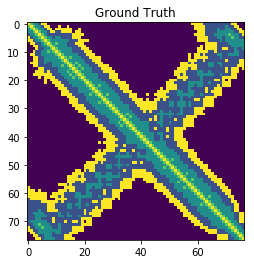

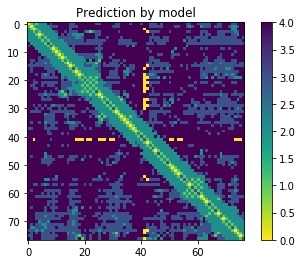

In [76]:
plt.title('Ground Truth')
plt.imshow(np.argmax(outputs[i], axis=2)[:len(seqs[i]), :len(seqs[i])], cmap='viridis_r', interpolation='nearest')
plt.show()

# Then plot predictions by the model - v2
plt.title("Prediction by model")
plt.imshow(preds4[:len(seqs[i]), :len(seqs[i])], cmap='viridis_r', interpolation='nearest')
plt.colorbar()
plt.show()

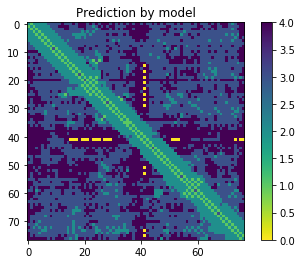

In [80]:
#plt.title('Ground Truth')
#plt.imshow(np.argmax(outputs[i], axis=2)[:len(seqs[i]), :len(seqs[i])], cmap='viridis_r', interpolation='nearest')
#plt.show()
#
# Then plot predictions by the model - v2
plt.title("Prediction by model")
plt.imshow(preds4[:len(seqs[i]), :len(seqs[i])], cmap='viridis_r', interpolation='nearest')
plt.colorbar()
plt.show()

In [81]:
print(np.argmax(outputs[i], axis=2)[60:65, :5])

[[0 0 0 0 0]
 [0 0 0 0 0]
 [3 0 0 0 0]
 [3 3 3 3 3]
 [3 3 3 3 3]]
